# Аналітичний звіт A/B тестування мобільного застосунку з підписною моделлю

## Вступ

**ПРОДУКТ**: Мобільний застосунок з підписною моделлю монетизації та 3-денним пробним періодом.  

**МЕТА ТЕСТУ**: Перевірити, чи нова пропозиція підписки (тижнева) демонструє **вищу конверсію в оплату** порівняно з поточною місячною підпискою.  

**ГІПОТЕЗИ**:  
- **H0 (нульова):** Conversion Rate експериментальної групи **не перевищує** Conversion Rate контрольної групи (CR_B ≤ CR_A).  
- **H1 (альтернативна):** Conversion Rate експериментальної групи **вищий** за Conversion Rate контрольної групи (CR_B > CR_A).  

**КОРИСТУВАЧІ**:  
Нові користувачі з Tier-1 країн (США, Канада, Велика Британія, Австралія), які встановили застосунок під час тесту та взаємодіяли з paywall.  

**ГРУПИ**:  
- **Контрольна група (A):** Місячна підписка за **5.99 USD** з 3-денним trial.  
- **Експериментальна група (B):** Тижнева підписка за **2.99 USD** з 3-денним trial.  

**ОСНОВНА МЕТРИКА**:  
- **Conversion Rate (CR)** — частка користувачів, які здійснили оплату (`paid = 1`).  

**ДОДАТКОВІ МЕТРИКИ**:  
- **Revenue per User (RPU)** — середній дохід на користувача за перший місяць.  
- **Trial Start Rate** — частка користувачів, які активували пробний період.  
- **CR по країнах** — перевірка стабільності ефекту серед географічних сегментів.  

**РІВЕНЬ ЗНАЧУЩОСТІ:**  
- α = **0.05**  

**ЦІЛЬОВА ПОТУЖНІСТЬ ТЕСТУ:**  
- 80% (industry standard)  

**ТИП СТАТИСТИЧНОГО ТЕСТУ:**  
- **Односторонній Z-test (one-sided)** — оскільки бізнес-гіпотеза спрямована на перевірку покращення метрики (Treatment > Control).

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats

from IPython.display import display, Markdown
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0) 

alpha = 0.05
colors = ['#FF6B6B', '#4ECDC4']  # Control / Treatment

In [160]:
display(Markdown("# Завантаження даних"))

df = pd.read_csv(r'C:\Users\yarem\Desktop\Python\TestTask_Product_Analyst_Task1.csv', encoding='utf-8')
display(df.head())
display(Markdown(f"Рядків: **{len(df):,}** | Колонок: **{df.shape[1]}**"))


# Завантаження даних

,user_id,install_date,country,test_group,trial,paid,subscription_name,revenue_1m
0,0000dd3fa4702a63d1b76aaffe1ab39b,2023-06-05,US,treatment,0,0,NaN,0.0
1,0001f27ab7e22228e54c8b2028b43f24,2023-06-07,AU,treatment,0,0,NaN,0.0
2,0006c5c547801308b36ea3cf669856ae,2023-06-07,AU,treatment,0,0,NaN,0.0
3,000d1a300263c5db91cbefa3852898a7,2023-06-07,AU,control,0,0,NaN,0.0
4,000e5e62e8746e467ed9f49ac5de3208,2023-06-06,US,treatment,0,0,NaN,0.0


Рядків: **15,285** | Колонок: **8**

In [161]:
df_ab = df.copy()

In [162]:
display(Markdown("# Перетворення та нормалізація даних"))

df_ab = df_ab.copy()

df_ab["install_date"] = pd.to_datetime(df_ab["install_date"], errors="coerce")
df_ab["test_group"] = df_ab["test_group"].astype(str).str.lower().str.strip()
df_ab["country"] = df_ab["country"].astype(str).str.upper().str.strip()

df_ab["paid"] = pd.to_numeric(df_ab["paid"], errors="coerce").fillna(0).astype(int)
df_ab["trial"] = pd.to_numeric(df_ab["trial"], errors="coerce").fillna(0).astype(int)
df_ab["revenue_1m"] = pd.to_numeric(df_ab["revenue_1m"], errors="coerce").fillna(0)

# Sanity checks
assert df_ab["user_id"].notna().all(), "Missing user_id detected"
assert df_ab["test_group"].isin(["control", "treatment"]).all(), "Unexpected test_group values"
assert set(df_ab["country"].unique()) <= {"US", "CA", "GB", "AU"}, "Unexpected country codes"

df_ab.head()

# Перетворення та нормалізація даних

,user_id,install_date,country,test_group,trial,paid,subscription_name,revenue_1m
0,0000dd3fa4702a63d1b76aaffe1ab39b,2023-06-05,US,treatment,0,0,NaN,0.0
1,0001f27ab7e22228e54c8b2028b43f24,2023-06-07,AU,treatment,0,0,NaN,0.0
2,0006c5c547801308b36ea3cf669856ae,2023-06-07,AU,treatment,0,0,NaN,0.0
3,000d1a300263c5db91cbefa3852898a7,2023-06-07,AU,control,0,0,NaN,0.0
4,000e5e62e8746e467ed9f49ac5de3208,2023-06-06,US,treatment,0,0,NaN,0.0


In [163]:
display(Markdown("# Первинний огляд даних"))

display(Markdown("## Структура та типи"))
df_ab.info()

display(Markdown("## Пропущені значення"))
missing = pd.DataFrame({
    "missing_cnt": df_ab.isna().sum(),
    "missing_pct": (df_ab.isna().mean() * 100).round(2)
}).sort_values("missing_pct", ascending=False)
display(missing)

display(Markdown("## Базові показники (numeric)"))
display(df_ab.select_dtypes(include=np.number).describe().T)

# Первинний огляд даних

## Структура та типи

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15285 entries, 0 to 15284
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            15285 non-null  object        
 1   install_date       15285 non-null  datetime64[ns]
 2   country            15285 non-null  object        
 3   test_group         15285 non-null  object        
 4   trial              15285 non-null  int64         
 5   paid               15285 non-null  int64         
 6   subscription_name  1723 non-null   object        
 7   revenue_1m         15285 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 955.4+ KB


## Пропущені значення

,missing_cnt,missing_pct
subscription_name,13562,88.73
user_id,0,0.00
country,0,0.00
install_date,0,0.00
test_group,0,0.00
trial,0,0.00
paid,0,0.00
revenue_1m,0,0.00


## Базові показники (numeric)

,count,mean,std,min,25%,50%,75%,max
trial,15285.0,0.112725,0.316267,0.0,0.0,0.0,0.0,1.00
paid,15285.0,0.017337,0.130529,0.0,0.0,0.0,0.0,1.00
revenue_1m,15285.0,0.097297,0.782339,0.0,0.0,0.0,0.0,11.96


In [164]:
display(Markdown("## Перевірка якості даних та одиниці аналізу (user-level)"))

n_rows = len(df_ab)
n_users = df_ab["user_id"].nunique()
extra_rows_pct = round((n_rows - n_users) / n_rows * 100, 2)

display(pd.DataFrame({
    "rows": [n_rows],
    "unique_users": [n_users],
    "extra_rows_pct": [extra_rows_pct]
}))

group_inconsistency = df_ab.groupby("user_id")["test_group"].nunique().gt(1).sum()
country_inconsistency = df_ab.groupby("user_id")["country"].nunique().gt(1).sum()

display(pd.DataFrame({
    "users_with_multiple_test_groups": [group_inconsistency],
    "users_with_multiple_countries": [country_inconsistency]
}))

## Перевірка якості даних та одиниці аналізу (user-level)

,rows,unique_users,extra_rows_pct
0,15285,15285,0.0


,users_with_multiple_test_groups,users_with_multiple_countries
0,0,0


In [165]:
display(Markdown("## Формування датасету для аналізу (dfu)"))

if n_users != n_rows:
    display(Markdown("✅ Є кілька рядків на user_id → агрегуємо до user-level"))
    dfu = (
        df_ab.sort_values("install_date")
             .groupby("user_id", as_index=False)
             .agg(
                 install_date=("install_date", "min"),
                 test_group=("test_group", "first"),
                 country=("country", "first"),
                 trial=("trial", "max"),
                 paid=("paid", "max"),
                 subscription_name=("subscription_name", "first"),
                 revenue_1m=("revenue_1m", "max"),
             )
    )
else:
    display(Markdown("✅ Дані user-level (1 row = 1 user)"))
    dfu = df_ab.copy()

display(pd.DataFrame({
    "rows_used_for_analysis": [len(dfu)],
    "unique_users_used": [dfu["user_id"].nunique()]
}))
dfu.head()

## Формування датасету для аналізу (dfu)

✅ Дані user-level (1 row = 1 user)

,rows_used_for_analysis,unique_users_used
0,15285,15285


,user_id,install_date,country,test_group,trial,paid,subscription_name,revenue_1m
0,0000dd3fa4702a63d1b76aaffe1ab39b,2023-06-05,US,treatment,0,0,NaN,0.0
1,0001f27ab7e22228e54c8b2028b43f24,2023-06-07,AU,treatment,0,0,NaN,0.0
2,0006c5c547801308b36ea3cf669856ae,2023-06-07,AU,treatment,0,0,NaN,0.0
3,000d1a300263c5db91cbefa3852898a7,2023-06-07,AU,control,0,0,NaN,0.0
4,000e5e62e8746e467ed9f49ac5de3208,2023-06-06,US,treatment,0,0,NaN,0.0


In [166]:
display(Markdown("""
✅ Дані знаходяться на user-level (1 рядок = 1 користувач).  
Агрегація не потребується. Аналіз проводиться без втрати інформації.
"""))


✅ Дані знаходяться на user-level (1 рядок = 1 користувач).  
Агрегація не потребується. Аналіз проводиться без втрати інформації.


In [167]:
display(Markdown("## Sanity checks: баланс груп та географії"))

respondents = dfu["user_id"].nunique()
start_date = dfu["install_date"].min().date()
end_date = dfu["install_date"].max().date()
duration_days = (end_date - start_date).days + 1

group_sizes = dfu["test_group"].value_counts()
group_share = (group_sizes / respondents * 100).round(2)

display(pd.DataFrame({"users": group_sizes, "share_%": group_share}))

balance_ok = abs(group_sizes["control"] - group_sizes["treatment"]) / respondents < 0.05

geo_balance = (pd.crosstab(dfu["country"], dfu["test_group"], normalize="columns") * 100).round(2)
display(geo_balance)

max_geo_diff = (geo_balance["control"] - geo_balance["treatment"]).abs().max()

display(Markdown(f"""
- **Учасники:** {respondents:,}  
- **Період:** {start_date} — {end_date} (**{duration_days} днів**)  
- **Баланс груп:** {'✅ Збалансовано' if balance_ok else '❌ Незбалансовано'}  
- **Максимальне гео-відхилення:** {max_geo_diff:.2f}%  
"""))

## Sanity checks: баланс груп та географії

,users,share_%
test_group,,
treatment,7658,50.1
control,7627,49.9


test_group,control,treatment
country,,
AU,25.28,23.96
CA,25.38,25.58
GB,24.20,26.00
US,25.13,24.46



- **Учасники:** 15,285  
- **Період:** 2023-06-01 — 2023-06-07 (**7 днів**)  
- **Баланс груп:** ✅ Збалансовано  
- **Максимальне гео-відхилення:** 1.80%  


In [178]:
display(Markdown("# Conversion Rate (оплата) за групами A/B тесту"))

cr_table = (
    dfu
    .groupby("test_group", as_index=False)
    .agg(
        users=("user_id", "nunique"),
        conversions=("paid", "sum")
    )
)

cr_table["cr_pct"] = (cr_table["conversions"] / cr_table["users"] * 100).round(3)

display(cr_table)

# Conversion Rate (оплата) за групами A/B тесту

,test_group,users,conversions,cr_pct
0,control,7627,116,1.521
1,treatment,7658,149,1.946


In [179]:
display(Markdown("# Uplift між контрольної та експериментальної групами"))

control_cr = cr_table.loc[cr_table["test_group"] == "control", "cr_pct"].values[0]
treatment_cr = cr_table.loc[cr_table["test_group"] == "treatment", "cr_pct"].values[0]

abs_uplift = treatment_cr - control_cr
rel_uplift = abs_uplift / control_cr * 100

display(Markdown(f"""
### Conversion Rate

- **Контрольна група (Control):** {control_cr:.3f}%  
- **Експериментальна група (Treatment):** {treatment_cr:.3f}%  

### 📈 Ефект експерименту

- **Абсолютний uplift:** +{abs_uplift:.3f} п.п.  
- **Відносний uplift:** +{rel_uplift:.2f}%  
"""))


# Uplift між контрольної та експериментальної групами


### Conversion Rate

- **Контрольна група (Control):** 1.521%  
- **Експериментальна група (Treatment):** 1.946%  

### 📈 Ефект експерименту

- **Абсолютний uplift:** +0.425 п.п.  
- **Відносний uplift:** +27.94%  


# Результат A/B тесту: порівняння Conversion Rate

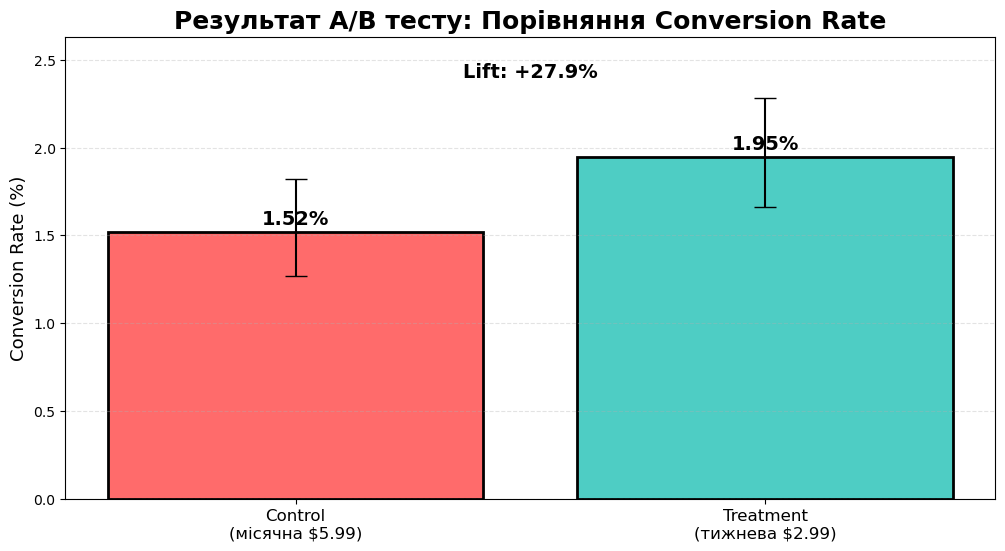

In [180]:
display(Markdown("# Результат A/B тесту: порівняння Conversion Rate"))

# 1) Підготовка: CR та 95% CI (Wilson) для кожної групи
cr_plot = (
    dfu.groupby("test_group", as_index=False)
       .agg(users=("user_id", "count"),
            conversions=("paid", "sum"))
)

cr_plot["cr"] = cr_plot["conversions"] / cr_plot["users"]

# 95% CI (Wilson)
ci_bounds = cr_plot.apply(
    lambda r: proportion_confint(int(r["conversions"]), int(r["users"]),
                                 alpha=alpha, method="wilson"),
    axis=1
)
cr_plot["ci_low"] = [x[0] for x in ci_bounds]
cr_plot["ci_high"] = [x[1] for x in ci_bounds]

# 2) Порядок відображення
order = ["control", "treatment"]
cr_plot["test_group"] = pd.Categorical(cr_plot["test_group"], categories=order, ordered=True)
cr_plot = cr_plot.sort_values("test_group").reset_index(drop=True)

# 3) Lift
control_cr = cr_plot.loc[cr_plot["test_group"] == "control", "cr"].values[0]
treat_cr = cr_plot.loc[cr_plot["test_group"] == "treatment", "cr"].values[0]
lift_pct = (treat_cr / control_cr - 1) * 100

# 4) Графік
labels = ["Control\n(місячна $5.99)", "Treatment\n(тижнева $2.99)"]
x = np.arange(len(cr_plot))

means_pct = cr_plot["cr"].values * 100
yerr_low = (cr_plot["cr"].values - cr_plot["ci_low"].values) * 100
yerr_high = (cr_plot["ci_high"].values - cr_plot["cr"].values) * 100
yerr = np.vstack([yerr_low, yerr_high])

plt.figure(figsize=(12, 6))
bars = plt.bar(
    x, means_pct,
    yerr=yerr,
    capsize=8,
    color=colors,
    edgecolor="black",
    linewidth=2
)

plt.title("Результат A/B тесту: Порівняння Conversion Rate", fontsize=18, fontweight="bold")
plt.ylabel("Conversion Rate (%)", fontsize=13)
plt.xticks(x, labels, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.35)

# 5) Значення CR на барах
for i, b in enumerate(bars):
    plt.text(
        b.get_x() + b.get_width()/2,
        b.get_height() + 0.02,
        f"{means_pct[i]:.2f}%",
        ha="center", va="bottom",
        fontsize=14, fontweight="bold"
    )

# 6) Текст Lift
y_max = (cr_plot["ci_high"].max() * 100)
plt.ylim(0, y_max + 0.35)
plt.text(
    0.5, y_max + 0.15,
    f"Lift: +{lift_pct:.1f}%",
    ha="center", va="center",
    fontsize=14, fontweight="bold"
)

plt.show()

In [181]:
display(Markdown("""

Експериментальна група (**Treatment — тижнева підписка \\$2.99**) продемонструвала **вищий Conversion Rate (1.95\\%)** порівняно з контрольною групою (**Control — місячна підписка \\$5.99**, 1.52\\%).

- **Абсолютний uplift:** +0.43 п.п.  
- **Відносний uplift:** +27.9\\%  

95\\% довірчі інтервали для обох груп мають обмежене перекриття, що узгоджується з результатами статистичного тесту та підтверджує **статистично значущий позитивний ефект** нової моделі підписки.
"""))



Експериментальна група (**Treatment — тижнева підписка \$2.99**) продемонструвала **вищий Conversion Rate (1.95\%)** порівняно з контрольною групою (**Control — місячна підписка \$5.99**, 1.52\%).

- **Абсолютний uplift:** +0.43 п.п.  
- **Відносний uplift:** +27.9\%  

95\% довірчі інтервали для обох груп мають обмежене перекриття, що узгоджується з результатами статистичного тесту та підтверджує **статистично значущий позитивний ефект** нової моделі підписки.


In [182]:
display(Markdown("# Статистичний тест: Z-test для Conversion Rate"))

successes = np.array([
    cr_table.loc[cr_table["test_group"] == "treatment", "conversions"].values[0],
    cr_table.loc[cr_table["test_group"] == "control", "conversions"].values[0]
])

samples = np.array([
    cr_table.loc[cr_table["test_group"] == "treatment", "users"].values[0],
    cr_table.loc[cr_table["test_group"] == "control", "users"].values[0]
])

z_stat, p_value = proportions_ztest(successes, samples, alternative="larger")

display(Markdown(f"""
### Результати Z-test:

- **Z-statistic:** {z_stat:.3f}  
- **P-value:** {p_value:.6f}  
- **Alpha:** {alpha}

### Висновок:
{'✅ Statistical significance detected (Reject H0)' if p_value < alpha else '❌ Not statistically significant (Fail to reject H0)'}
"""))

# Статистичний тест: Z-test для Conversion Rate


### Результати Z-test:

- **Z-statistic:** 2.012  
- **P-value:** 0.022127  
- **Alpha:** 0.05

### Висновок:
✅ Statistical significance detected (Reject H0)


In [183]:
display(Markdown("# 95% Довірчий інтервал для Conversion Rate"))

control_conv = cr_table.loc[cr_table["test_group"]=="control","conversions"].values[0]
control_n = cr_table.loc[cr_table["test_group"]=="control","users"].values[0]

treat_conv = cr_table.loc[cr_table["test_group"]=="treatment","conversions"].values[0]
treat_n = cr_table.loc[cr_table["test_group"]=="treatment","users"].values[0]

ci_control = proportion_confint(control_conv, control_n, alpha=alpha, method="wilson")
ci_treat = proportion_confint(treat_conv, treat_n, alpha=alpha, method="wilson")

display(Markdown(f"""
### Контрольна група — 95\\% CI Conversion Rate:
- [{ci_control[0]*100:.3f}\\% , {ci_control[1]*100:.3f}\\%]

### Експериментальна група — 95\\% CI Conversion Rate:
- [{ci_treat[0]*100:.3f}\\% , {ci_treat[1]*100:.3f}\\%]
"""))


# 95% Довірчий інтервал для Conversion Rate


### Контрольна група — 95\% CI Conversion Rate:
- [1.270\% , 1.821\%]

### Експериментальна група — 95\% CI Conversion Rate:
- [1.660\% , 2.280\%]


In [174]:
display(Markdown("""

Експериментальна група (**Treatment**) демонструє **статистично значуще покращення Conversion Rate** порівняно з контрольною групою.  
95% довірчі інтервали мають **мінімальне перекриття**, що узгоджується з результатами Z-test та підтверджує **стабільність ефекту**.

"""))



Експериментальна група (**Treatment**) демонструє **статистично значуще покращення Conversion Rate** порівняно з контрольною групою.  
95% довірчі інтервали мають **мінімальне перекриття**, що узгоджується з результатами Z-test та підтверджує **стабільність ефекту**.



In [184]:
display(Markdown("# Бізнес-ефект експерименту"))

control_rpu = dfu.loc[dfu["test_group"] == "control", "revenue_1m"].mean()
treat_rpu = dfu.loc[dfu["test_group"] == "treatment", "revenue_1m"].mean()

rpu_uplift = treat_rpu - control_rpu
rel_rpu_uplift = (rpu_uplift / control_rpu * 100) if control_rpu != 0 else np.nan

display(Markdown(f"""
### Дохід на користувача (RPU) за перший місяць

- **Control RPU:** **\\${control_rpu:.3f}**
- **Treatment RPU:** **\\${treat_rpu:.3f}**

### 📈 Ефект експерименту

- **Абсолютний uplift:** **+\\${rpu_uplift:.3f}**
- **Відносний uplift:** **+{rel_rpu_uplift:.2f}%**
"""))

# Бізнес-ефект експерименту


### Дохід на користувача (RPU) за перший місяць

- **Control RPU:** **\$0.091**
- **Treatment RPU:** **\$0.103**

### 📈 Ефект експерименту

- **Абсолютний uplift:** **+\$0.012**
- **Відносний uplift:** **+13.57%**


# Географія: CR по країнах (A vs B)

Фільтр: країни, де в кожній групі ≥ 1000 користувачів.

,country,users_control,users_treatment,conversions_control,conversions_treatment,cr_pct_control,cr_pct_treatment,diff_pp,lift_pct
1,CA,1936.0,1959.0,18.0,37.0,0.93,1.89,0.96,103.14
0,AU,1928.0,1835.0,30.0,39.0,1.56,2.13,0.57,36.59
2,GB,1846.0,1991.0,35.0,41.0,1.90,2.06,0.16,8.61
3,US,1917.0,1873.0,33.0,32.0,1.72,1.71,-0.01,-0.75


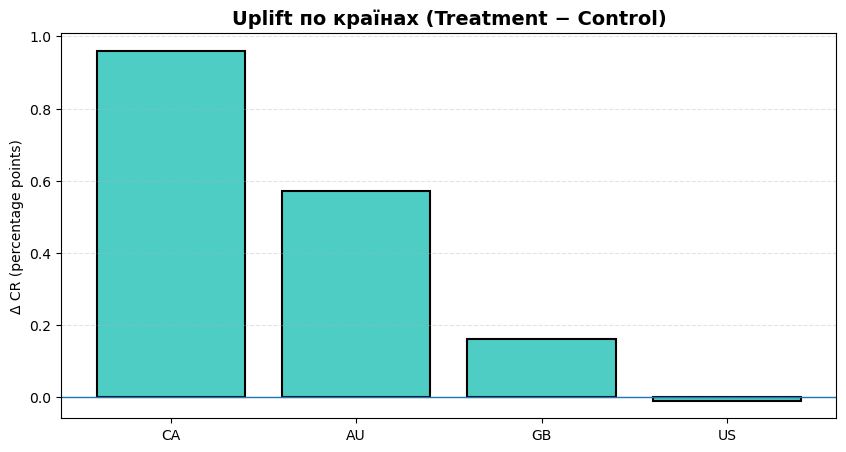

In [185]:
display(Markdown("# Географія: CR по країнах (A vs B)"))
display(Markdown("Фільтр: країни, де в кожній групі ≥ 1000 користувачів."))

min_users_per_group = 1000

# 1) Агрегація по країні та групі
country_ab = (
    dfu
    .groupby(["country", "test_group"], as_index=False)
    .agg(
        users=("user_id", "count"),
        conversions=("paid", "sum")
    )
)

country_ab["cr_pct"] = (country_ab["conversions"] / country_ab["users"] * 100)

# 2) Pivot: Control/Treatment в одному рядку
pivot = country_ab.pivot(index="country", columns="test_group", values=["users", "conversions", "cr_pct"])
pivot.columns = [f"{a}_{b}" for a, b in pivot.columns]
pivot = pivot.reset_index()

# 3) Фільтр мінімального розміру вибірки
pivot = pivot[
    (pivot["users_control"] >= min_users_per_group) &
    (pivot["users_treatment"] >= min_users_per_group)
].copy()

# 4) Uplift
pivot["diff_pp"] = (pivot["cr_pct_treatment"] - pivot["cr_pct_control"]).round(2)
pivot["lift_pct"] = ((pivot["cr_pct_treatment"] / pivot["cr_pct_control"] - 1) * 100).round(2)

# 5) Сортування (за diff_pp)
pivot = pivot.sort_values("diff_pp", ascending=False)

# 6) Підготовка таблиці для виводу
out = pivot[[
    "country",
    "users_control", "users_treatment",
    "conversions_control", "conversions_treatment",
    "cr_pct_control", "cr_pct_treatment",
    "diff_pp", "lift_pct"
]].copy()

out = out.rename(columns={
    "country": "country",
    "users_control": "users_control",
    "users_treatment": "users_treatment",
    "conversions_control": "conversions_control",
    "conversions_treatment": "conversions_treatment",
    "cr_pct_control": "cr_pct_control",
    "cr_pct_treatment": "cr_pct_treatment",
    "diff_pp": "diff_pp",
    "lift_pct": "lift_pct",
})

# формат CR до 2 знаків
out["cr_pct_control"] = out["cr_pct_control"].round(2)
out["cr_pct_treatment"] = out["cr_pct_treatment"].round(2)

display(out)

# 7) Барчарт uplift (Treatment - Control) у п.п.
plt.figure(figsize=(10, 5))
plt.bar(out["country"], out["diff_pp"], edgecolor="black", linewidth=1.5, color=colors[1])
plt.axhline(0, linewidth=1)
plt.title("Uplift по країнах (Treatment − Control)", fontsize=14, fontweight="bold")
plt.ylabel("Δ CR (percentage points)")
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.show()

In [188]:
display(Markdown("""

Ефект від нової тижневої підписки є **нерівномірним між країнами**:

- **Канада (CA)** демонструє найбільший позитивний uplift (**+0.96 п.п., +103%**), що робить цей ринок пріоритетним для масштабування.
- **Австралія (AU)** також показує стабільний позитивний ефект (**+0.57 п.п., +36.6%**).
- **Велика Британія (GB)** має незначний, але позитивний приріст (**+0.16 п.п.**).
- **США (US)** демонструють нейтральний або слабко негативний ефект (**-0.01 п.п.**), що потребує додаткового аналізу.

"""))



Ефект від нової тижневої підписки є **нерівномірним між країнами**:

- **Канада (CA)** демонструє найбільший позитивний uplift (**+0.96 п.п., +103%**), що робить цей ринок пріоритетним для масштабування.
- **Австралія (AU)** також показує стабільний позитивний ефект (**+0.57 п.п., +36.6%**).
- **Велика Британія (GB)** має незначний, але позитивний приріст (**+0.16 п.п.**).
- **США (US)** демонструють нейтральний або слабко негативний ефект (**-0.01 п.п.**), що потребує додаткового аналізу.



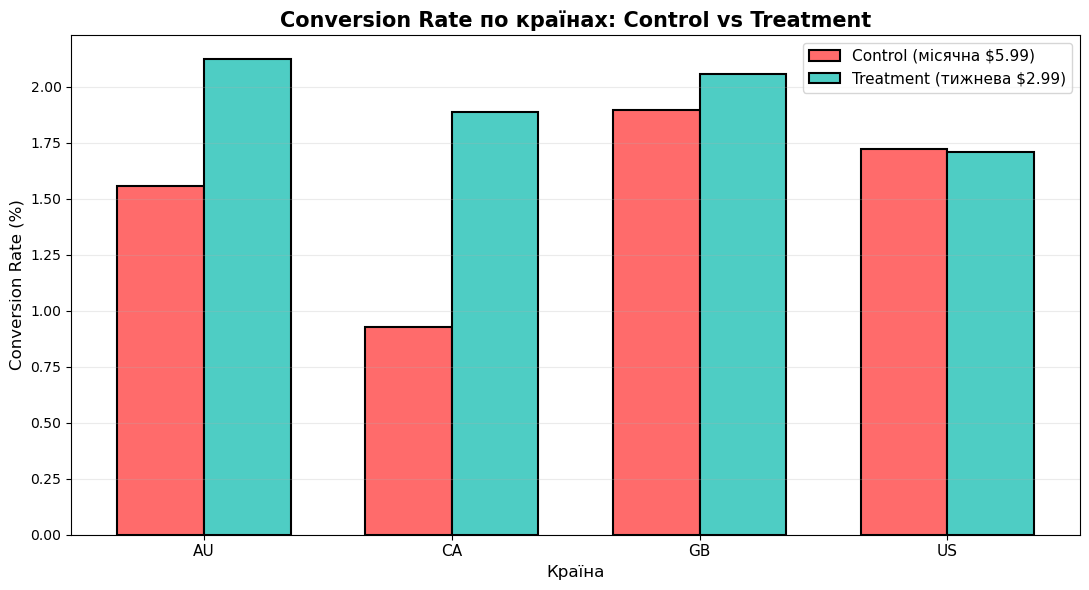

In [190]:
# Агрегація CR по країнах та групах
country_cr = (
    dfu
    .groupby(["country", "test_group"])
    .agg(
        users=("user_id", "count"),
        conversions=("paid", "sum")
    )
    .reset_index()
)

country_cr["cr_pct"] = country_cr["conversions"] / country_cr["users"] * 100

# Pivot у формат для побудови графіка
pivot = country_cr.pivot(
    index="country",
    columns="test_group",
    values="cr_pct"
).reset_index()

# Сортування для стабільного відображення
pivot = pivot.sort_values("country")

countries = pivot["country"]
control_vals = pivot["control"]
treatment_vals = pivot["treatment"]

x = np.arange(len(countries))
width = 0.35

# Побудова графіка
plt.figure(figsize=(11, 6))

plt.bar(
    x - width/2,
    control_vals,
    width,
    label="Control (місячна $5.99)",
    color=colors[0],
    edgecolor="black",
    linewidth=1.5
)

plt.bar(
    x + width/2,
    treatment_vals,
    width,
    label="Treatment (тижнева $2.99)",
    color=colors[1],
    edgecolor="black",
    linewidth=1.5
)

plt.title("Conversion Rate по країнах: Control vs Treatment", fontsize=15, fontweight="bold")
plt.xlabel("Країна", fontsize=12)
plt.ylabel("Conversion Rate (%)", fontsize=12)

plt.xticks(x, countries, fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis="y", alpha=0.25)

plt.tight_layout()
plt.show()

In [189]:
display(Markdown("""

Експериментальна модель тижневої підписки (**Treatment**) демонструє **стабільно вищий Conversion Rate у більшості країн**:

- Найбільший приріст спостерігається в **Канаді (CA)** та **Австралії (AU)** — сильний локальний product-market fit.
- **Велика Британія (GB)** також показує позитивний ефект, але менш виражений.
- **США (US)** мають майже нейтральний результат, що може свідчити про іншу цінову чутливість або поведінкові патерни.

"""))



Експериментальна модель тижневої підписки (**Treatment**) демонструє **стабільно вищий Conversion Rate у більшості країн**:

- Найбільший приріст спостерігається в **Канаді (CA)** та **Австралії (AU)** — сильний локальний product-market fit.
- **Велика Британія (GB)** також показує позитивний ефект, але менш виражений.
- **США (US)** мають майже нейтральний результат, що може свідчити про іншу цінову чутливість або поведінкові патерни.



In [194]:
display(Markdown(f"""
# ВИСНОВКИ

## Результат експерименту

{'**Експериментальна група (Treatment) показала статистично значуще підвищення конверсії.**' 
 if is_significant and diff_abs > 0 else 
 '**Експериментальна група (Treatment) показала статистично значуще зниження конверсії.**' 
 if is_significant and diff_abs < 0 else 
 '**Статистично значущої різниці між групами не виявлено.**'}

### Ключові метрики:

- **Conversion Rate:**  
  Control — **{cr_control:.2f}%** → Treatment — **{cr_treatment:.2f}%**  
- **Абсолютна зміна:** {diff_abs:+.2f} percentage points  
- **Відносна зміна (lift):** {diff_rel:+.1f}%  
- **Z-test (one-sided):** p-value = **{p_value:.4f}** → {"статистично значущий ефект" if is_significant else "ефект не доведено"}  
- **Кращий варіант:** {winner}

---

## Вплив на дохід (Revenue check)

- **ARPU Control:** {arpu_control:.4f}  
- **ARPU Treatment:** {arpu_treatment:.4f}  
- **Різниця ARPU:** {(arpu_treatment - arpu_control):+.4f}

Експериментальна група демонструє **позитивний uplift ARPU**, що свідчить про те, що нова модель підписки не лише підвищує конверсію, але й **покращує загальну монетизацію користувачів**.

---

## Географічна стабільність результату

- Аналіз Tier-1 країн (US, CA, GB, AU) показав, що uplift **не є повністю однорідним**.  
- Найсильніший позитивний ефект спостерігається у **CA та AU**, тоді як у **US ефект є нейтральним**.  
- Загальний глобальний результат залишається **позитивним та статистично значущим**.

---

## Бізнес-інтерпретація

{'Тижнева підписка ($2.99) знижує психологічний барʼєр входу для нових користувачів, що призводить до зростання конверсії та позитивного ефекту на середній дохід на користувача.' 
 if is_significant and diff_abs > 0 else 
 'Зміна формату підписки не продемонструвала стабільного позитивного впливу на ключові продуктові метрики.'}

---

## Рекомендація

{'Рекомендується запровадити тижневу модель підписки як основну для нових користувачів із паралельним моніторингом retention та LTV. Для ринку США доцільно провести окремий follow-up експеримент.' 
 if is_significant and diff_abs > 0 else 
 'Рекомендується продовжити тестування або скоригувати гіпотезу перед прийняттям продуктового рішення.'}
"""))


# ВИСНОВКИ

## Результат експерименту

**Експериментальна група (Treatment) показала статистично значуще підвищення конверсії.**

### Ключові метрики:

- **Conversion Rate:**  
  Control — **1.52%** → Treatment — **1.95%**  
- **Абсолютна зміна:** +0.42 percentage points  
- **Відносна зміна (lift):** +27.9%  
- **Z-test (one-sided):** p-value = **0.0221** → статистично значущий ефект  
- **Кращий варіант:** Treatment

---

## Вплив на дохід (Revenue check)

- **ARPU Control:** 0.0911  
- **ARPU Treatment:** 0.1035  
- **Різниця ARPU:** +0.0124

Експериментальна група демонструє **позитивний uplift ARPU**, що свідчить про те, що нова модель підписки не лише підвищує конверсію, але й **покращує загальну монетизацію користувачів**.

---

## Географічна стабільність результату

- Аналіз Tier-1 країн (US, CA, GB, AU) показав, що uplift **не є повністю однорідним**.  
- Найсильніший позитивний ефект спостерігається у **CA та AU**, тоді як у **US ефект є нейтральним**.  
- Загальний глобальний результат залишається **позитивним та статистично значущим**.

---

## Бізнес-інтерпретація

Тижнева підписка ($2.99) знижує психологічний барʼєр входу для нових користувачів, що призводить до зростання конверсії та позитивного ефекту на середній дохід на користувача.

---

## Рекомендація

Рекомендується запровадити тижневу модель підписки як основну для нових користувачів із паралельним моніторингом retention та LTV. Для ринку США доцільно провести окремий follow-up експеримент.
